In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.parse import unquote

In [3]:
df_articles = pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", delimiter = '\t', comment = '#', names=['article'])
df_links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", delimiter = '\t', comment = '#', names = ['article','link'])
df_finished_paths = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", delimiter = '\t', comment = '#', names = ['hashedIpAddress','timestamp','durationInSec','path','rating'])
df_unfinished_paths = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", delimiter = '\t', comment = '#', names = ['hashedIpAddress','timestamp','durationInSec','path','target','type'])
df_categories = pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", delimiter = '\t', comment = '#', names = ['article','category'])

In [4]:
df_articles['article'] = df_articles['article'].apply(unquote)
df_links['article'] = df_links['article'].apply(unquote)
df_links['link'] = df_links['link'].apply(unquote)
df_finished_paths['path'] = df_finished_paths['path'].apply(unquote)
df_unfinished_paths['path'] = df_unfinished_paths['path'].apply(unquote)
df_unfinished_paths['target'] = df_unfinished_paths['target'].apply(unquote)
df_categories['article'] = df_categories['article'].apply(unquote)

In [34]:
df_links_outdegree = df_links.copy()
df_links_outdegree.columns = ['article','out_degrees']
out_degrees = df_links_outdegree.groupby('article').count()
df_links_indegree = df_links.copy()
df_links_indegree.columns = ['in_degrees','article']
in_degrees = df_links_indegree.groupby('article').count()

In [35]:
print(in_degrees.loc['United_States'].values)
print(out_degrees.loc['United_States'].values)

[1551]
[294]


In [36]:
out_degrees.sort_values(by='out_degrees', ascending=False)

,out_degrees
article,
United_States,294
Driving_on_the_left_or_right,255
List_of_countries,244
List_of_circulating_currencies,236
List_of_sovereign_states,216
...,...
Emma_Roberts,1
All_your_base_are_belong_to_us,1
Lighting_designer,1


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(

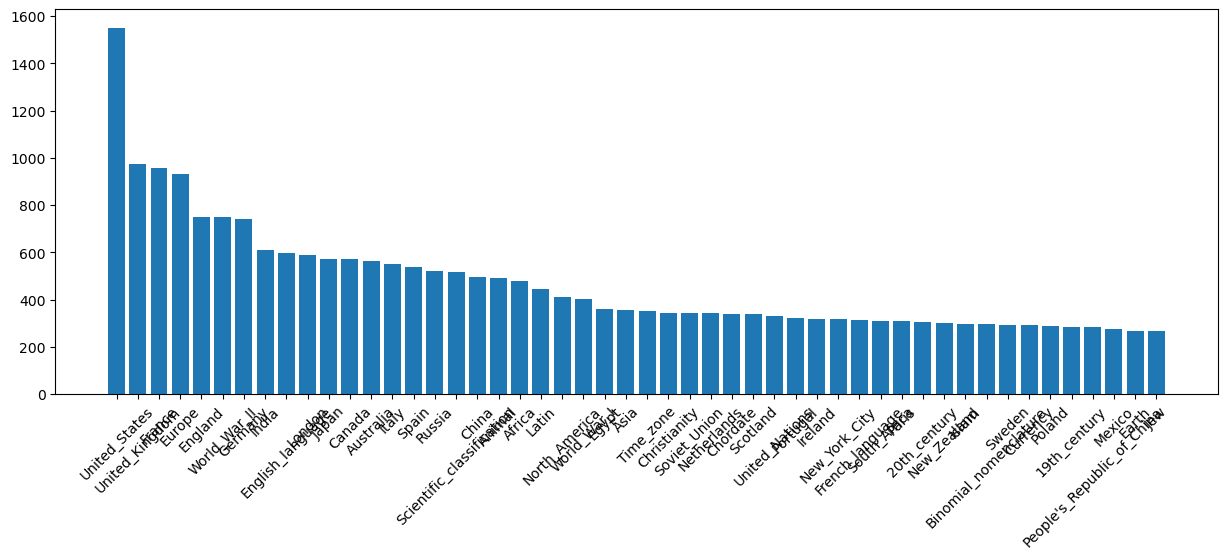

In [41]:
fig = plt.figure(figsize=(15,5))

in_degrees.sort_values(by='in_degrees', ascending=False, inplace=True)
plt.bar(in_degrees[:50].index, in_degrees[:50]['in_degrees'])
plt.xticks(rotation=45)

In [22]:
df_subcategories = df_categories.copy()
df_subcategories['category'].str.split('.', expand=True).shape
df_subcategories[['subject', 'category','subcategory','subsubcategory']] = df_subcategories['category'].str.split('.', expand=True)
df_subcategories.drop(columns=['subject'], inplace=True)
display(df_subcategories)

,article,category,subcategory,subsubcategory
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None
...,...,...,...,...
5199,Zirconium,Science,Chemistry,Chemical_elements
5200,Zoroaster,People,Religious_figures_and_leaders,None
5201,Zuid-Gelders,Geography,European_Geography,None
5202,Zuid-Gelders,Language_and_literature,Languages,None
